# US Corporate Misconduct Analyses

## 1. Problem Statement

From Enron's massive accounting fraud to Facebook's data privacy scandal, corporate misconduct seems to have occupied the 24 hour news cycle every so often. In an age that corporate firms are deeply involved in every aspects of our lives, corporate ethics  and social responsibilities have never been so important today. By analyzing public US corporate misconduct filing and proceedings data, I want to expose patterns in correlation to company ownership, size, and other factors, if there is any. But more importantly, it is a way to raise public awareness of the damage and impact of these corporate misbehavior, as a way to address the growing importance of corporate responsibility  and self-regulation.

#### Data Source
In 2014, [Goodjobsfirst](https://www.goodjobsfirst.org/violation-tracker) published the first comprehensive datasets of corporate violation data compiled from a list of government agencies, court proceedings, and filings. It has since been tracking these data as part of its corporate research project. This study utilizes these data to analyse corporate misconducts that happened between 2000 and 2018, with a focus on firms that are headquartered in the US only. A full list of data source can be found and downloaded [here].

## 2. Data clean and prep

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from wordcloud import WordCloud

In [3]:
# initial explore
cols_keep = ['Company', 'Parent Company', 'Penalty Amount','Penalty Year', 'Penalty Date', 'Primary Offense', 'Secondary Offense',
             'Level of Government', 'Agency', 'Court', 'Civil/Criminal', 'Lawsuit Resolution','HQ State of Parent',
            'Ownership Structure', 'Parent Company Stock Ticker', 'Major Industry of Parent', 'Specific Industry of Parent']
df = pd.read_csv("potential_topic/corp_miscon/US_Corp_Vio_2000-2019.csv", usecols = cols_keep)
df.columns = ['company', 'parent', 'penalty', 'year', 'date', 'primary_offence', 'secondary_offence', 'level_gov', 'gov_agency', 'court',
             'civil_criminal', 'resolution', 'hq_state', 'ownership', 'parent_ticker', 'industry', 'sub_industry']
df.shape

C:\Users\ygao\.virtualenvs\incubator-KUPcr2N5\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (13,18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(65060, 17)

In [4]:
# data types
df.infer_objects()

# change date column to datetime
df['date'] = pd.to_datetime(df.date, format='%Y%m%d', infer_datetime_format=True, errors='coerce')
df = df.dropna(subset=['date'])

# strip penalty column and change to int
df['penalty'] = df['penalty'].str.replace(',', '')
df['penalty'] = df['penalty'].str.replace('$', '')
df['penalty'] = pd.to_numeric(df['penalty'])

# cast year column as int
df['year'] = pd.to_numeric(df['year'])

df.dtypes

company                      object
parent                       object
penalty                       int64
year                          int64
date                 datetime64[ns]
primary_offence              object
secondary_offence            object
level_gov                    object
gov_agency                   object
court                        object
civil_criminal               object
resolution                   object
hq_state                     object
ownership                    object
parent_ticker                object
industry                     object
sub_industry                 object
dtype: object

In [5]:
df.head(5)

,company,parent,penalty,year,date,primary_offence,secondary_offence,level_gov,gov_agency,court,civil_criminal,resolution,hq_state,ownership,parent_ticker,industry,sub_industry
0,CATHOLIC HEALTHCARE WEST SOUTHERN CALIFORNIA (...,CommonSpirit Health,45000,2001,2001-10-22,labor relations violation,NaN,federal,National Labor Relations Board,NaN,civil,NaN,Illinois,non-profit,NaN,healthcare services,healthcare services
1,"Waste Management of Missouri, Inc. d/b/a Waste...",Waste Management,23000,2001,2001-03-02,labor relations violation,NaN,federal,National Labor Relations Board,NaN,civil,NaN,Texas,publicly traded,WM,waste management and environmental services,waste management
2,180 Connect Inc,AT&T,96475,2007,2007-05-07,wage and hour violation,Fair Labor Standards Act,federal,Labor Department Wage and Hour Division,NaN,civil,NaN,Texas,publicly traded,T,telecommunications,telecommunications
3,"180 Connect, Inc.",AT&T,47588,2004,2004-09-25,wage and hour violation,Fair Labor Standards Act,federal,Labor Department Wage and Hour Division,NaN,civil,NaN,Texas,publicly traded,T,telecommunications,telecommunications
4,1st Financial Bank USA,1st Financial Bank USA,10140000,2010,2010-01-29,banking violation,NaN,federal,Federal Deposit Insurance Corporation,NaN,civil,NaN,South Dakota,privately held,NaN,financial services,banking


## 3. Initial exploration

### a). corp ownership structure comparison

In [6]:
# create bigger ownership buckets, as the ownership column is too granular
ownership_list = df.ownership.unique().tolist()
key_buckets = ['privately held', 'publicly traded', 'non-profit', 'out of business']
df_owner = df[['ownership', 'year', 'company', 'penalty']]
df_owner['ownership_buckets'] = np.where(df_owner['ownership'].isin(key_buckets), df_owner['ownership'], 'others')

# aggregate and display
agg_dict = { (k):('count' if k != 'penalty' else 'sum') for k in df_owner.columns }
df_owner = df_owner.groupby(['year','ownership_buckets']).agg(agg_dict)
df_owner.penalty = df_owner.penalty/1000000000 # dollar amount in billion
df_owner_summary = df_owner
df_owner.sample(9)

C:\Users\ygao\.virtualenvs\incubator-KUPcr2N5\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,,ownership,year,company,penalty,ownership_buckets
year,ownership_buckets,,,,,
2012,non-profit,37,37,37,0.349274,37
2015,privately held,1002,1002,1002,0.842173,1002
2004,non-profit,26,26,26,0.065144,26
2005,out of business,13,13,13,0.715177,13
2002,others,41,41,41,0.001229,41
2019,publicly traded,91,91,91,2.622477,91
2000,privately held,244,244,244,0.424137,244
2017,privately held,711,711,711,0.945017,711
2016,privately held,678,678,678,0.766624,678


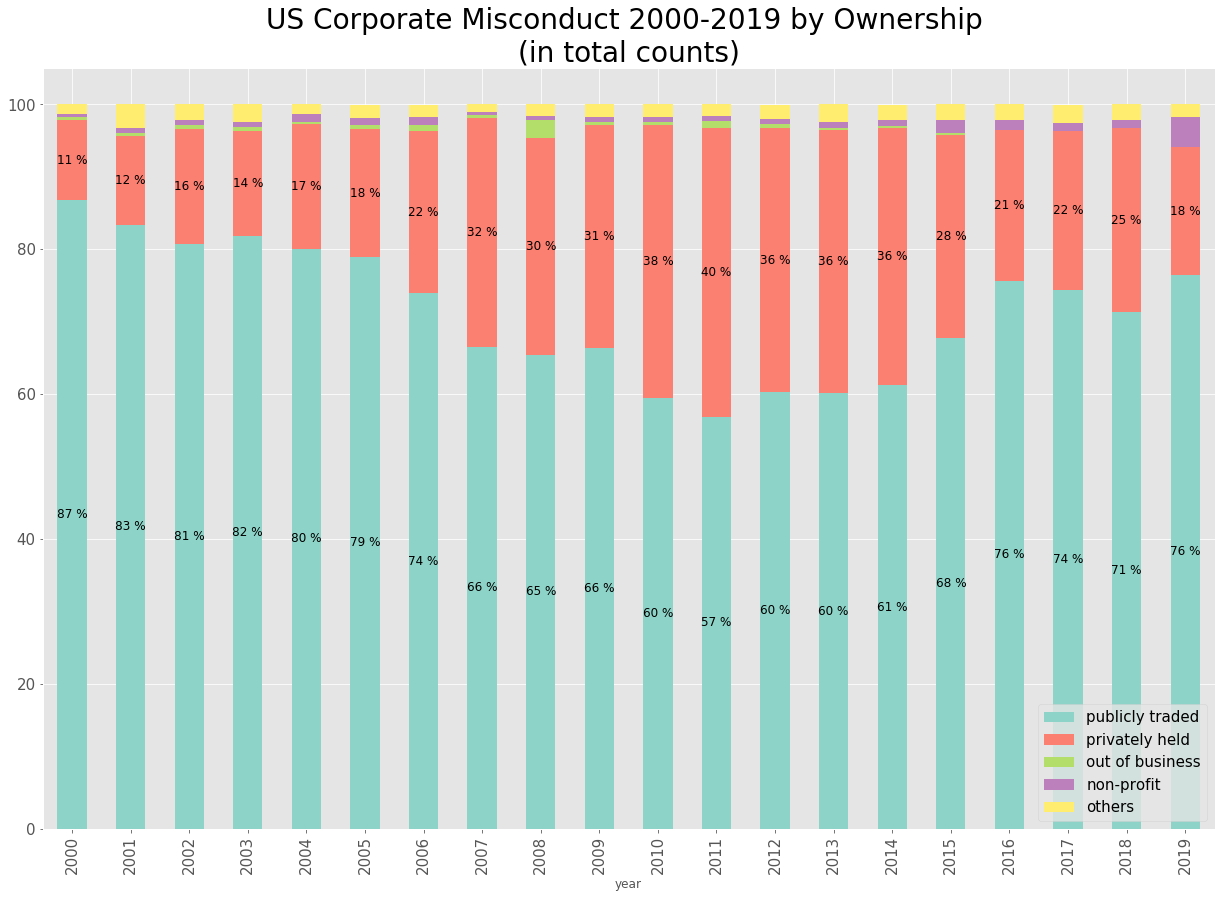

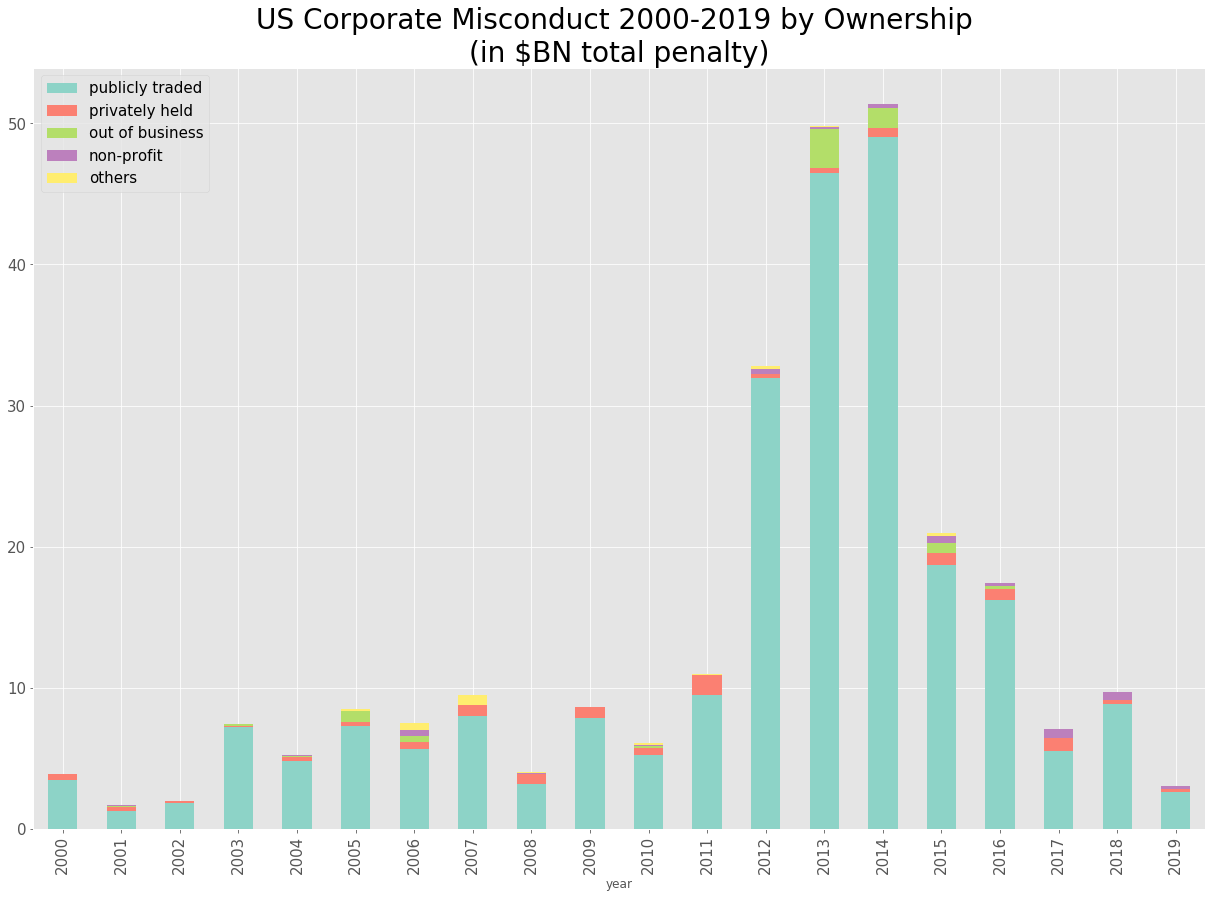

In [7]:
# interactive visualization
# cfl.set_config_file(offline=False, world_readable=True, theme='ggplot')
# chart = pd.DataFrame(df_owner['company'])
# chart.iplot(kind='barh',barmode='stack', bargap=.1, filename='by_ownership')

# pick colors
cmap = plt.get_cmap('Set3')

# static visualization
plt.style.use('ggplot')

# plt.figtext(0.5,0.1, 'US Corporate Misconduct 2000-2019, by ownership', fontsize=25, ha='center')

# data - by count
owner_ct = pd.DataFrame(df_owner['company']).reset_index()
owner_ct = owner_ct.pivot(index='year', columns='ownership_buckets', values='company')
owner_ct = owner_ct.loc[:,['publicly traded','privately held', 'out of business', 'non-profit', 'others']]
owner_ct['sum'] = owner_ct.sum(axis=1)
for n in owner_ct.columns[:5]:
    pct = np.round(owner_ct[n]/owner_ct['sum'],3)*100
    owner_ct[n] = pct

# data - by $$
owner_amt = pd.DataFrame(df_owner['penalty']).reset_index()
owner_amt = owner_amt.pivot(index='year', columns='ownership_buckets', values='penalty')
owner_amt = owner_amt.loc[:,['publicly traded','privately held', 'out of business', 'non-profit', 'others']]
# owner_amt['sum'] = owner_amt.sum(axis=1)
# for n in owner_amt.columns[:5]:
#     pct2 = np.round(owner_amt[n]/owner_amt['sum'],3)*100
#     owner_amt[n] = pct2

# vertical stack bar
ct = owner_ct.loc[:,['publicly traded','privately held', 'out of business', 'non-profit', 'others']] \
.plot(kind='bar', stacked=True, cmap=cmap, figsize=(21,14), fontsize=15)
ct.legend(fontsize = 15, loc='lower right')
plt.title('US Corporate Misconduct 2000-2019 by Ownership \n(in total counts)', fontsize= 28)

ss = owner_amt.loc[:,['publicly traded','privately held', 'out of business', 'non-profit', 'others']] \
.plot(kind='bar', stacked=True, cmap=cmap, figsize=(21,14), fontsize=15)
ss.legend(fontsize = 15, loc='upper left')
plt.title('US Corporate Misconduct 2000-2019 by Ownership \n(in $BN total penalty)', fontsize= 28)

# include % onotation on each bar
for p in ct.patches:
    width, height = p.get_width(), p.get_height()
    if height >= 5:
        x, y = p.get_xy() 
        ct.text(x+width/2, y+height/2, '{:.0f} %'.format(height), horizontalalignment='center', verticalalignment='center', fontsize = 12)

# display summary tables

Public companies has, suprisingly, dominated both the dollar amount and the total count of misconduct. (You would think that going public would make them more responsible, because more regulatory requirements and public scrutiny...)

### b). industry breakdown

In [8]:
# aggregate and display
df_ind = df[['industry', 'company', 'penalty']]
df_ind['penalty'] = df_ind['penalty']/1000000000
agg_dict={'company':'count', 'penalty':'sum'}
df_ind_agg = df_ind.groupby(['industry']).agg(agg_dict)
df_ind_agg2 = df_ind.groupby(['industry']).agg(agg_dict)

# df_ind.sample(9)
df_ind_mean = df_ind.groupby(['industry']).mean()
df_ind_ct = df_ind_agg.reset_index().sort_values(by=['company'], ascending=False)
df_ind_p = df_ind_agg2.reset_index().sort_values(by=['penalty'], ascending=False)
df_ind_p.sample(5)

C:\Users\ygao\.virtualenvs\incubator-KUPcr2N5\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,industry,company,penalty
2,airlines,2886,0.691775
42,restaurants and foodservice,447,0.386629
36,paper and packaging,1010,0.151351
30,miscellaneous manufacturing,1137,0.603119
24,information technology,224,5.693627


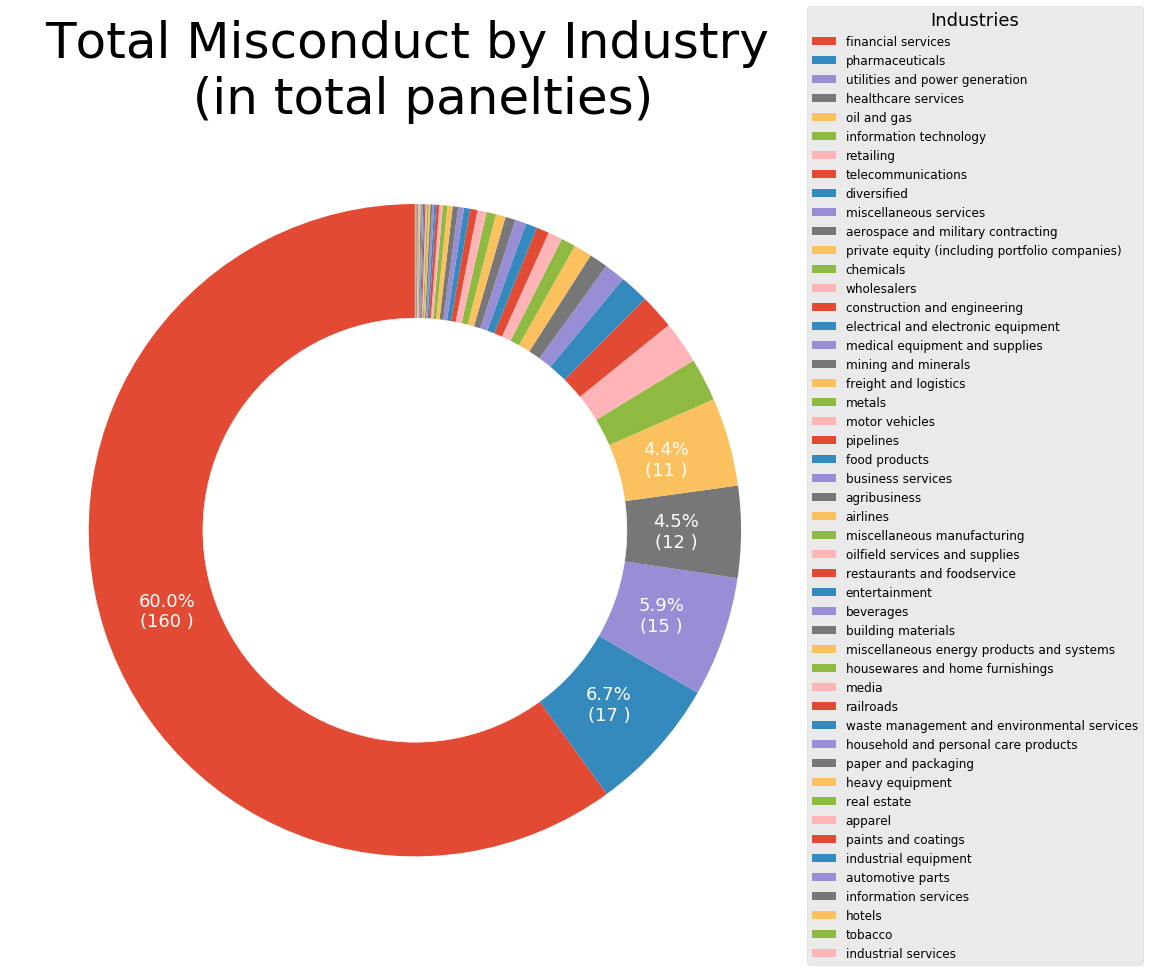

In [54]:
# donut chart to visualize overall 
labels_p = df_ind_p.industry.tolist()
labels_c = df_ind_ct.industry.tolist()
panelties = df_ind_p.penalty.tolist()
counts = df_ind_ct.company.tolist()

# Create a circle for the center of the plot
circle=plt.Circle((0,0), 0.65, color='white')

pie_fig = plt.figure(figsize=[15, 15])
ax = pie_fig.add_subplot(111)
ax.set_title("Total Misconduct by Industry \n (in total panelties)", fontsize=50, color='black')
plt.rcParams['font.size'] = 18

# label conditional hide
def my_autopct(pct, allvals, unit):
    absolute=int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} {})".format(pct, absolute, unit) if pct>3 else ""


wedges, texts, autotexts = ax.pie(panelties, autopct=lambda pct: my_autopct(pct, panelties, ''),
                                  textprops=dict(color="w"),startangle=90,pctdistance=0.8,)


# wedges, texts, autotexts = ax.pie(, autopct=lambda pct: my_autopct(pct, panelties),
#                                   textprops=dict(color="w"),startangle=90,pctdistance=0.8,)

ax.legend(wedges, labels_p,title="Industries", fontsize = 12, bbox_to_anchor=(0.15,0.15,1.25, 1), loc='upper right') #loc="upper right",plt.setp(autotexts, size=25, weight="bold")


# plot pie
# plt.pie(panelties, autopct=my_autopct, labels=labels_p, 
#                          pctdistance=0.8, labeldistance=1.1, colors=colors, startangle=90) #'%1.1f%%'
p=plt.gcf()
p.gca().add_artist(circle)
# pie_ax.axis('equal')

plt.show()

Finance industry has a whopping $160 billion dollars in total fines from 2000-2019, which account for 60% of the entire profile across all industries!

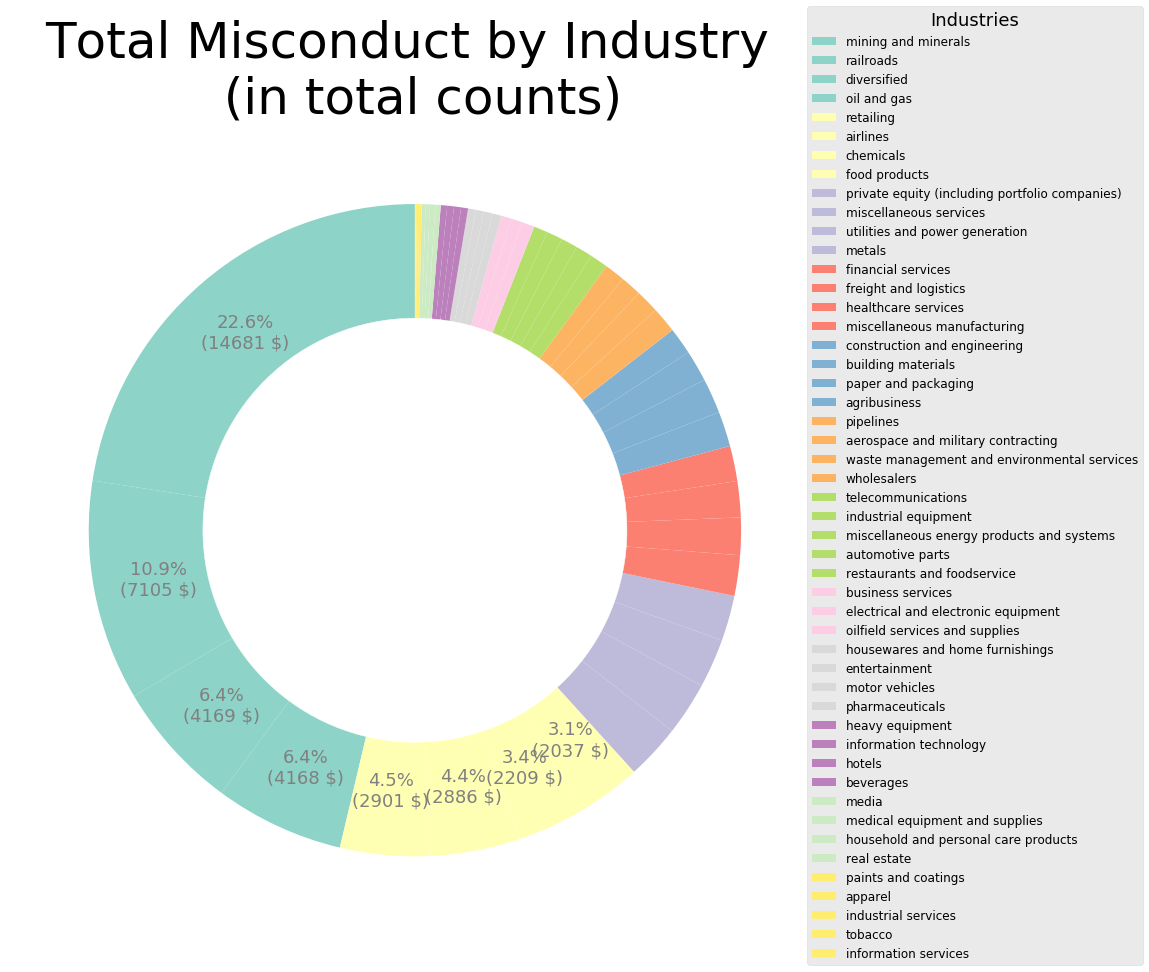

In [55]:
 # Create a circle for the center of the plot
circle=plt.Circle((0,0), 0.65, color='white')

pie_fig = plt.figure(figsize=[15, 15])
ax = pie_fig.add_subplot(111)
ax.set_title("Total Misconduct by Industry \n (in total counts)", fontsize=50, color='black')

# label conditional hide
def my_autopct(pct, allvals, unit):
    absolute=int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d} {})".format(pct, absolute, unit) if pct>3 else ""

colors=cmap(np.linspace(0., 1., len(labels_c)))
wedges, texts, autotexts = ax.pie(counts, autopct=lambda pct: my_autopct(pct, counts, '$'),colors=colors,
                                  textprops=dict(color="grey"),startangle=90,pctdistance=0.8,)


ax.legend(wedges, labels_c,title="Industries", fontsize = 12, bbox_to_anchor=(0.15,0.15,1.25, 1), loc='upper right') #loc="upper right",plt.setp(autotexts, size=25, weight="bold")


# plot pie
# plt.pie(panelties, autopct=my_autopct, labels=labels_p, 
#                          pctdistance=0.8, labeldistance=1.1, colors=colors, startangle=90) #'%1.1f%%'
p=plt.gcf()
p.gca().add_artist(circle)
# pie_ax.axis('equal')

plt.show()

### c). Take a deeper look at finance

In [12]:
df_all = df[['year','industry', 'company', 'penalty']]
df_finance = df_all[df_all.industry=='financial services']
df_finance['penalty'] = df_finance['penalty']/1000000000
df_finance = df_finance.sort_values(by='penalty', ascending=False)
df_finance.head(5)

C:\Users\ygao\.virtualenvs\incubator-KUPcr2N5\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,year,industry,company,penalty
2049,2014,financial services,Bank of America Corporation,16.6500
34799,2013,financial services,JPMorgan Chase,13.0000
2050,2012,financial services,Bank of America Corporation,10.9566
2030,2013,financial services,Bank of America,10.3500
2051,2014,financial services,Bank of America Corporation,9.3000


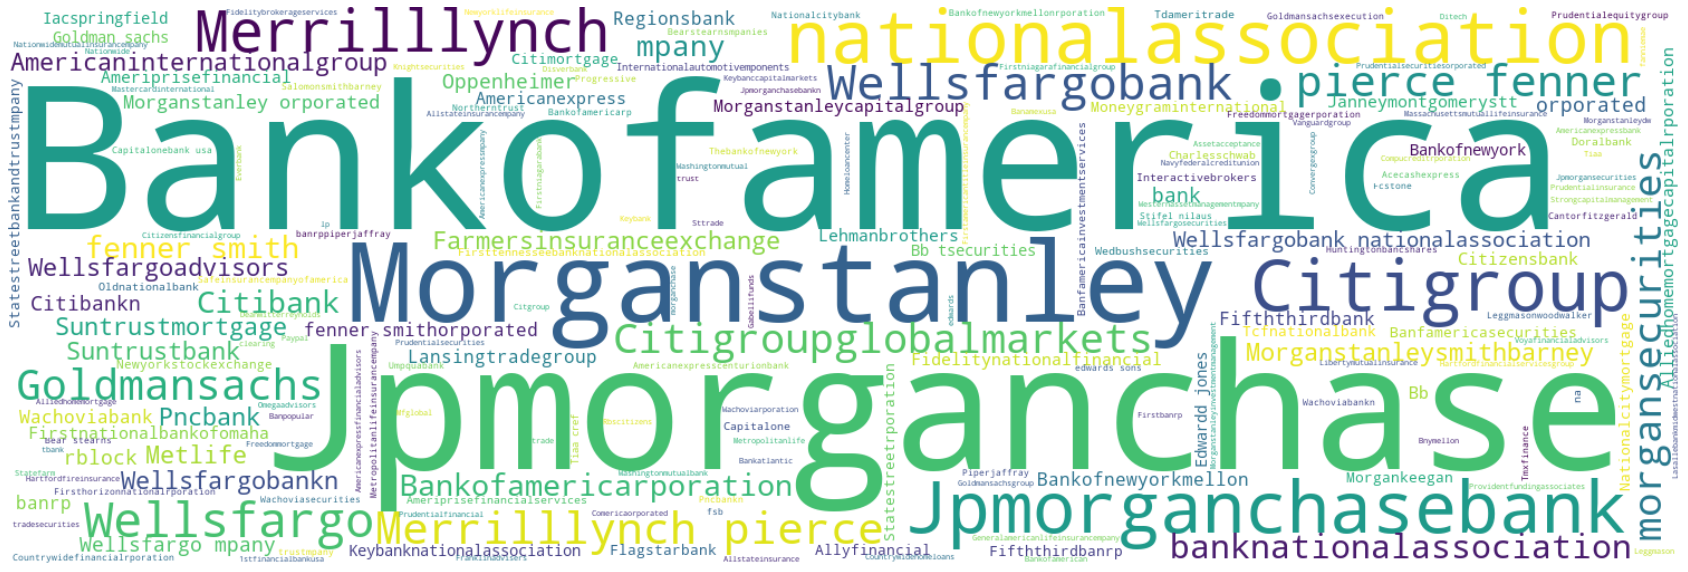

In [51]:
# create word cloud
cl_banks=[com.capitalize() for com in df_finance.company]
striped = [b.replace(' ', '') for b in cl_banks]
filtered = ['inc', 'co', 'llc']
for f in filtered:
    striped = [b.replace(f, '') for b in striped]
# striped = [b.replace(' ', '') for b in cl_banks]
# striped = [b.replace('inc', '') for b in striped]
# striped = [b.replace('co', '') for b in striped]
str_bnks = ' '.join(striped)

# Create the wordcloud object
bank_cloud = WordCloud(background_color='white', width=1500, height=500, margin=0).generate(str_bnks)
 
# Display the generated image:
plt.figure(figsize = (30, 30), facecolor = None) 
plt.imshow(bank_cloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('', fontsize=)
plt.show()